In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from PIL import Image, ImageDraw
import json
from stable_baselines3.common.env_checker import check_env

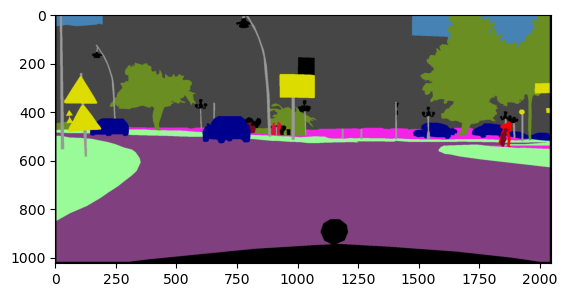

In [10]:
# Get image
PATH = '../data/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png'
image = Image.open(PATH)

# Display image
plt.imshow(image)
plt.show()

In [11]:
# Load the polygon label data
LABEL_PATH = '../data/gtFine/train/aachen/aachen_000000_000019_gtFine_polygons.json'
with open(LABEL_PATH) as f:
    polygons = json.load(f)
    
polygons 

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'label': 'road',
   'polygon': [[0, 769],
    [290, 574],
    [93, 528],
    [0, 524],
    [0, 448],
    [0, 448],
    [210, 453],
    [511, 451],
    [782, 459],
    [892, 495],
    [943, 498],
    [1044, 471],
    [1490, 486],
    [1880, 519],
    [1922, 512],
    [1975, 522],
    [2047, 524],
    [2047, 570],
    [1668, 553],
    [2047, 597],
    [2047, 1023],
    [892, 1023],
    [0, 1023]]},
  {'label': 'sidewalk',
   'polygon': [[2047, 532],
    [1911, 537],
    [1828, 540],
    [1782, 540],
    [1794, 552],
    [2047, 564]]},
  {'label': 'car',
   'polygon': [[806, 503],
    [803, 524],
    [796, 528],
    [785, 528],
    [778, 527],
    [776, 520],
    [771, 520],
    [768, 515],
    [732, 515],
    [728, 523],
    [722, 523],
    [715, 524],
    [714, 523],
    [711, 520],
    [709, 517],
    [706, 517],
    [702, 520],
    [697, 529],
    [690, 532],
    [681, 532],
    [678, 529],
    [674, 527],
    [671, 517],
    [635, 

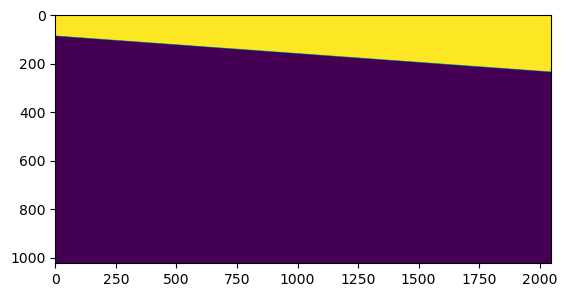

In [12]:
# Create a mask image
mask = Image.new('L', (polygons['imgWidth'], polygons['imgHeight']), 0)
draw = ImageDraw.Draw(mask)

# Draw the polygons for the current label
for obj in polygons['objects']:
    if obj['label'] == "sky":

        polygon = obj['polygon']
        # Convert list of lists to list of tuples
        polygon_tuples = [tuple(point) for point in polygon]
        draw.polygon(polygon_tuples, outline=1, fill=1)
        
mask_array = np.array(mask)
plt.imshow(mask_array)
plt.show()

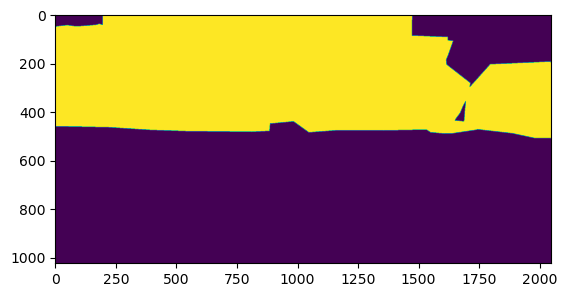

In [13]:
# Create a mask image
mask = Image.new('L', (polygons['imgWidth'], polygons['imgHeight']), 0)
draw = ImageDraw.Draw(mask)

# Draw the polygons for the current label
for obj in polygons['objects']:
    if obj['label'] == "building":

        polygon = obj['polygon']
        # Convert list of lists to list of tuples
        polygon_tuples = [tuple(point) for point in polygon]
        draw.polygon(polygon_tuples, outline=1, fill=1)
        
mask_array = np.array(mask)
plt.imshow(mask_array)
plt.show()

In [14]:
possible_labels = ['road', 'sidewalk', 'parking', 'rail track', 'person', 'rider', 'car', 'truck', 'bus', 'on rails', 'motorcycle', 'bicycle', 'caravan', 'trailer', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'pole group', 'traffic sign', 'traffic light', 'vegetation', 'terrain', 'sky', 'ground', 'dynamic', 'static']

height, width = polygons['imgHeight'], polygons['imgWidth']
num_labels = len(possible_labels)
combined_masks = np.zeros((height, width, num_labels), dtype=np.uint8)

for idx, label in enumerate(possible_labels):
    # Create a mask image
    mask = Image.new('L', (polygons['imgWidth'], polygons['imgHeight']), 0)
    draw = ImageDraw.Draw(mask)
    
    # Draw the polygons for the current label
    for obj in polygons['objects']:
        if obj['label'] == label:

            polygon = obj['polygon']
            # Convert list of lists to list of tuples
            polygon_tuples = [tuple(point) for point in polygon]
            draw.polygon(polygon_tuples, outline=1, fill=1)
            
    mask_array = np.array(mask)
    combined_masks[:, :, possible_labels.index(label)] = mask_array
    
# Save the combined masks array
np.save('output/combined_masks.npy', combined_masks)

In [17]:
combined_masks.shape

(1024, 2048, 30)

In [15]:
combined_masks[0,1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [8]:
from rl_environment import SegmentationEnv

image_array = np.array(image)
labels = np.argmax(combined_masks, axis=2)
env = SegmentationEnv(image_array, labels)

env.observation_space.shape


SyntaxError: invalid syntax (rl_environment.py, line 60)

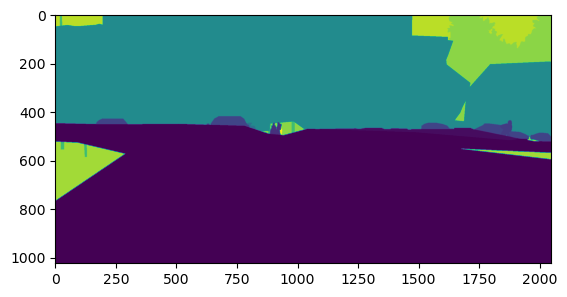

In [31]:
# show labeled image
plt.imshow(labels)


In [36]:
from rl_environment import SegmentationEnv

# Save image into numpy array
image_array = np.array(image)

# Get labels for each pixel of the image
labels = np.argmax(combined_masks, axis=2)

env = SegmentationEnv(image_array, labels)

# check_env(env, warn=True)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

obs = env.reset()

for i in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    if done:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/home/jaspe/mambaforge/envs/maps/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


MemoryError: Unable to allocate 48.0 GiB for an array with shape (2048, 1, 3, 1024, 2048) and data type float32